# Coding Tutorial 6 - Pretrained Computer Vision Models

```
Course: CSCI 5922 Spring 2025, University of Colorado Boulder
TA: Everley Tseng
Email: Yu-Yun.Tseng@colorado.edu
* AI assistant is used in making this tutorial
```

## Overview

Sections:
- Pretrained models in PyTorch
- Example 1: semantic segmentation
- Example 2: object detection
- Example 3: instance segmentation

Objectives:
- Learn how to identify and load pretrained models in PyTorch
- Run the pretrained models: FCN, Faster R-CNN, and Mask R-CNN

## Pretrained Models

In deep learning, a variety of phrases are used interchangeably to describe the **complete set of learned parameters** for a particular model architecture: "pretrained model", "pretrained weights", "model checkpoint", "state dict", and "weights file". In `torchvision`, the available pretrained models are listed on the [pretrained weights](https://pytorch.org/vision/0.20/models.html) page. Notably, in this context, **weights** refers to all parameters, which contrasts when we distinguish *weights* and *biases* as separate parameters (like kernel vs. bias) within individual layers.

Recall, we already practiced loading a pretrained ResNet model for classification in Coding Tutorial 4. Many more models are available for image classification and other tasks, including [semantic segmentation](https://pytorch.org/vision/0.20/models.html#semantic-segmentation), [object detection](https://pytorch.org/vision/0.20/models.html#object-detection), [instance segmentation](https://pytorch.org/vision/0.20/models.html#instance-segmentation), [keypoint detection](https://pytorch.org/vision/0.20/models.html#keypoint-detection), and [video classification](https://pytorch.org/vision/0.20/models.html#video-classification). Notably, models can be used *as is* and as *backbones* in larger architectures.

### Load and Run Pretrained Models

Below are the steps we will practice for our examples:

1. Scope the task:
  - Know what the model input is
  - Know what the model output is

2. Review the documentation:
  - Select a pretrained model matching the task input/output constraints

3. Run the sample code:
  - If available, adopt the sample code from the documentation
  - Apply the select architecture and its parameters to your input data and print/plot results

4. Analyze the code:
  - Print a characterization of the architecture

Below, we practice these steps with three examples, Semantic Segmentation, Object Detection, and Instance Segmentation.

In [ ]:
import os
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision.io.image import decode_image
from torchvision.transforms.functional import to_pil_image

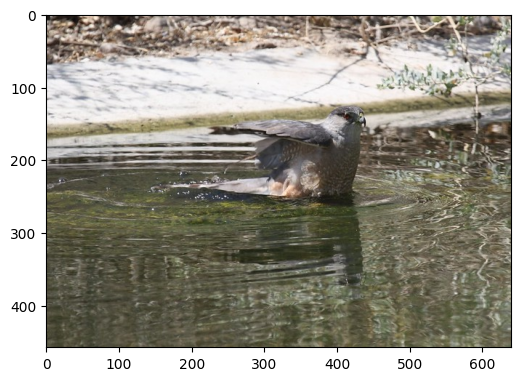

In [ ]:
import requests
from PIL import Image
from io import BytesIO

# Read image
url = 'http://farm4.staticflickr.com/3730/9455431370_d8b61be4e4_z.jpg'
# url = 'http://farm5.staticflickr.com/4095/4886266871_949e713af3_z.jpg'
# url = 'http://farm9.staticflickr.com/8040/7928721018_0b26a5b000_z.jpg'
byte_tensor = torch.frombuffer(requests.get(url).content, dtype=torch.uint8)
img = decode_image(byte_tensor)
pil_image = to_pil_image(img)

# Show image
plt.figure(figsize=(6,6))
plt.imshow(pil_image)
plt.show()

### Semantic Segmentation

1. Task overview:
  - Task input: an image
  - Task output: output resolution matches the input image size, indicating the pixel-wise classification result

2. Review PyTorch [documentation](https://pytorch.org/vision/0.20/models.html#semantic-segmentation) for semantic segmentation to choose a model:

  - Model architecture options: Select [FCN](https://pytorch.org/vision/0.20/models/fcn.html)
  - Pretrained weights: Select [`FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`](https://pytorch.org/vision/0.20/models/generated/torchvision.models.segmentation.fcn_resnet50.html#torchvision.models.segmentation.FCN_ResNet50_Weights)
  - These weights were trained on a subset of [COCO Dataset](https://cocodataset.org/#home), using the 20 categories present in the [Pascal VOC Dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/).

3. Adopt sample code and get the result:

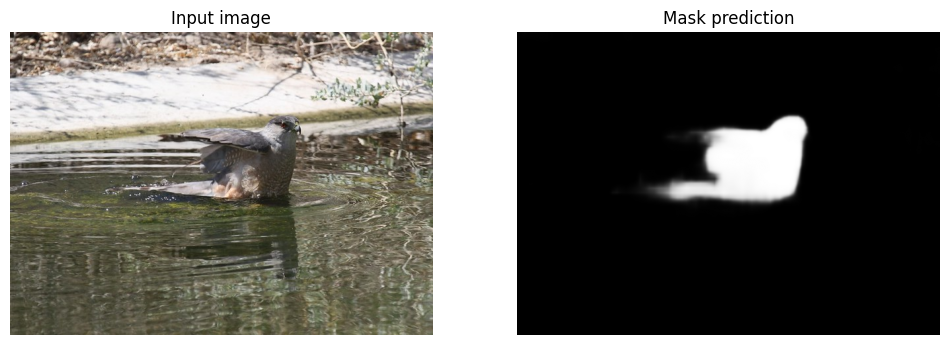

In [ ]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

# Step 1: Initialize model with the best available weights
weights = FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = fcn_resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Pass image to the model and get output
prediction = model(batch)["out"]
normalized_masks = prediction.softmax(dim=1)

# Step 5: Process the output
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
mask = normalized_masks[0, class_to_idx["bird"]]
pil_mask = to_pil_image(mask)

# Step 6: Visualize result
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(pil_image)
axes[0].set_title("Input image")
axes[0].axis('off')
axes[1].imshow(pil_mask, cmap='gray')
axes[1].set_title("Mask prediction")
axes[1].axis('off')
plt.show()

4. Learn from the code:

   Typically, the output of semantic segmentation is in the format of `[batch_size, category_size, height, width]`. From the code, we see that the model returns a dictionary, where the prediction mask is grabbed from `["out"]`.
   ```
   prediction = model(batch)["out"]
   ```
   From the cell below, we can see the shape of the prediction map is `(1, 21, 520, 726)`. This tensor is in the format of pixel-wise multi-class classification output. Therefore, every pixel's final prediction is based on the softmax output of the second dimension (category_size):
   ```
   normalized_masks = prediction.softmax(dim=1)
   ```
   You might notice that the model is stated to be trained on 20 categories, but there are 21 categories here. This is because in semantic segmentation, the category "background" is typically automatically added, so there are $20 + 1 = 21$ categories in total.

   The category information is usually stored in `weights.meta["categories"]`. Therefore, by an index conversion, we can get the pixel-wise category prediction, which is why we use these lines to acquire the prediction mask:
   ```
   class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
   mask = normalized_masks[0, class_to_idx["bird"]]
   ```

In [ ]:
print('Output prediction shape', prediction.shape)
print('All categories:\n', weights.meta["categories"])

Output prediction shape torch.Size([1, 21, 520, 726])
All categories:
 ['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


   For a complex model architecture packaged in `torchvision` (i.e., non-backbone models), we often can't apply `torchsummary.summary` directly. We instead can inspect the architecture with `print(model)`. Optionally, we are able to also summarize the model's submodules such as backbone structure.
   ```
   # backbone = model.backbone
   # summary(backbone, input_size=(image_size))
   ```
   However, the backbone structure **doens't include the entire model architecture**.

In [ ]:
# Print the entire model architecture
print('Model architecture:')
print(model)

# Summarize the backbone
# backbone = model.backbone
# summary(backbone, input_size=(3, 520, 520))

Model architecture:
FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (d

### Object Detection

1. Task overview:
  - Task input: an image
  - Task output: bounding box(es) of detected objects

2. See PyTorch [documentation](https://pytorch.org/vision/0.20/models.html#object-detection) for object detection to choose a model:

  - Model architecture options: Select [Faster R-CNN](https://pytorch.org/vision/0.20/models/faster_rcnn.html)
  - Pretrained weights: Select [`FasterRCNN_ResNet50_FPN_V2_Weights`](https://pytorch.org/vision/0.20/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn_v2.html#torchvision.models.detection.FasterRCNN_ResNet50_FPN_V2_Weights), which were trained on the [COCO Dataset](https://cocodataset.org/#home).


3. Adopt sample code and get the result:

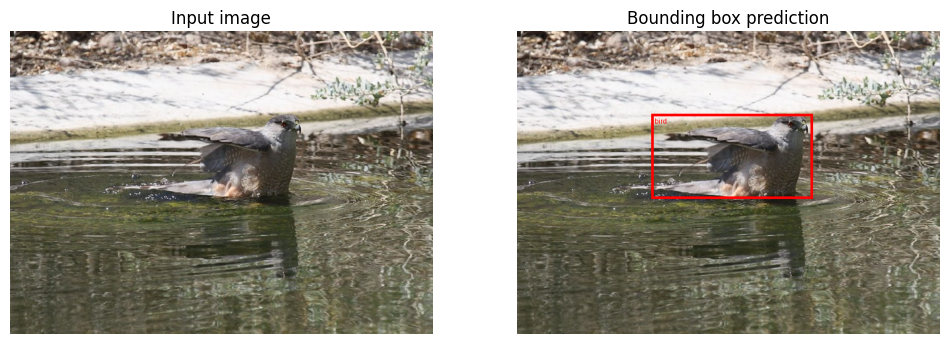

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes

# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Pass input data to the model
prediction = model(batch)[0]

# Step 5: Process output boxes and categories
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)

# Step 6: Visualize results
img_bbox = to_pil_image(box.detach())
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(pil_image)
axes[0].set_title("Input image")
axes[0].axis('off')
axes[1].imshow(img_bbox, cmap='gray')
axes[1].set_title("Bounding box prediction")
axes[1].axis('off')
plt.show()

4. Learn from the code:

   First, let's print the entire prediction. There are three elements, `boxes`, `labels`, and `scores`. For every predicted bounding box, we can get the box coordinates from the stack of `prediction['boxes']` and it's category label from the stack of `prediction['labels']`.

   Similar to semantic segmentation, we are able to see the list of categories from `weights.meta['categories']`.

   Bounding boxes are typically stored using four elements:
   ```
   [xmin, ymin, xmax, ymax] or [xmin, ymin, width, height]
   ```
   From the function [`draw_bounding_boxes`](https://pytorch.org/vision/main/generated/torchvision.utils.draw_bounding_boxes.html), we learn that the output format should be `[xmin, ymin, xmax, ymax]`. Below, let's practicing unpacking and processing the result of the first prediction.

In [ ]:
print('Model prediction:\n', prediction)
print('All categories:\n', weights.meta['categories'])
print()

bbox = prediction['boxes'][0]
label_id = prediction['labels'][0]
print('First bounding box xmin: {:.2f}, ymin: {:.2f}, xmax: {:.2f}, ymax: {:.2f}'.format(bbox[0], bbox[1], bbox[2], bbox[3]))
print('First label id: {}, category name: {}'.format(label_id, weights.meta['categories'][label_id]))

Model prediction:
 {'boxes': tensor([[203.0972, 125.3905, 447.0384, 253.5162]], grad_fn=<StackBackward0>), 'labels': tensor([16]), 'scores': tensor([0.9964], grad_fn=<IndexBackward0>)}
All categories:
 ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cel

Similar to semantic segmentation, you are able to print the model architecture:

In [ ]:
# Print the entire model architecture
print('Model architecture:')
print(model)

Model architecture:
FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

### Instance Segmentation

1. Task overview:
  - Task input: an image
  - Task output: masks of detected objects

2. Review PyTorch [documentation](https://pytorch.org/vision/0.20/models.html#instance-segmentation) for object detection to choose model:

  - Model architecture options: Select [Mask R-CNN](https://pytorch.org/vision/0.20/models/mask_rcnn.html)
  - Pretrained weights: Select [`MaskRCNN_ResNet50_FPN_V2_Weights`](https://pytorch.org/vision/0.20/models/generated/torchvision.models.detection.maskrcnn_resnet50_fpn_v2.html#torchvision.models.detection.MaskRCNN_ResNet50_FPN_V2_Weights), which were trained on the [COCO Dataset](https://cocodataset.org/#home).

3. Adopt sample code and modify the visualization step following the [visualization tutorial](https://pytorch.org/vision/0.20/auto_examples/others/plot_visualization_utils.html#sphx-glr-auto-examples-others-plot-visualization-utils-py):

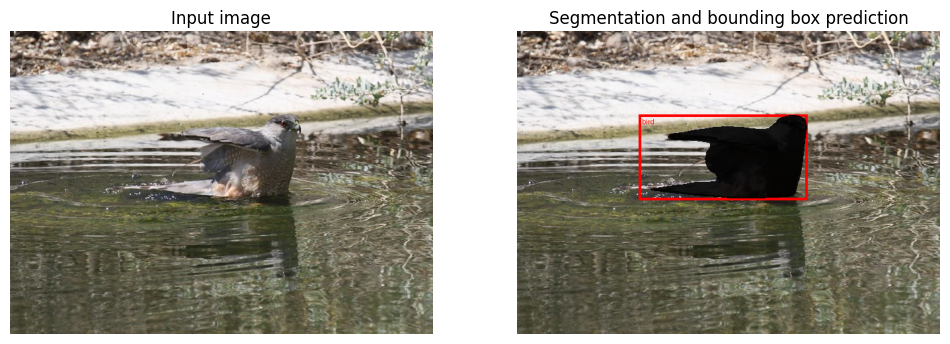

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

# Step 1: Initialize model with the best available weights
weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = maskrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Pass input data to the model
prediction = model(batch)[0]

# Step 5: Process output boxes and categories
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
masks = prediction['masks']
bool_masks = masks > 0.5
bool_masks = bool_masks.squeeze(1)

# Step 6: Visualize results
img_masks = draw_segmentation_masks(box, bool_masks, alpha=0.9)
img_masks = to_pil_image(img_masks.detach())
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(pil_image)
axes[0].set_title("Input image")
axes[0].axis('off')
axes[1].imshow(img_masks)
axes[1].set_title("Segmentation and bounding box prediction")
axes[1].axis('off')
plt.show()

4. Learn from the code:
   
   Instance Segmentation results are similar to Object Detection results. In Mask R-CNN, the RoI area is further processed for a pixel-wise prediction to more accurately locate the object. The acquire the mask, we use:
   ```
   masks = prediction['masks']
   ```
   The format of masks results should be `[ object_size, 1, height, width]`, which are the pixel-wise predictions of the detected objects. In PyTorch, these masks are already converted into the size of the input image, so we can conveniently map the pixel-wise predictions to the input image.
   
   However, when using other libraries/modules, the output could be a mask that maps to the bounding box area. To process the raw output, bias and resizing need to be applied before visualization.

In [ ]:
print(len(weights.meta['categories']))
print('All categories:\n', weights.meta['categories'])
print(masks.shape)

91
All categories:
 ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
torch.Size([1, 1, 458, 640])


Again, you can print the model architecture:

In [ ]:
print(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

## Review

When using a pretrained model to analyze images, there are various output types including index-to-category conversion, bounding boxes, and masks. Visualizing these prediction types can provide rich insight into a model's performance and help you debug.

Below are practice exercises you can try:
- Load a different image (i.e., use a different url in the second code cell) and run the three tasks to get prediction results.
- Load different localization models for each task and compare the results to the results above.

For any questions and discussions regarding this tutorial, attend [TA office hours](https://docs.google.com/spreadsheets/d/1fzfTJpEF7RaUYRA_NGa3DkiazdQXVj7QNBbp6DrEZ3I/edit?usp=sharing) or create a post on [Piazza](https://piazza.com/colorado/spring2025/csci5922/home) :) See you in the next tutorial!

\- Everley